In [38]:
import numpy as np
import pickle
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
from collections import defaultdict

In [3]:
CHEMPROP_RESULTS_PATH = 'results/motivational/chemprop/'
os.listdir(CHEMPROP_RESULTS_PATH)

['less_64_random_split.pickle',
 'less_128_random_split.pickle',
 'less_256_random_split.pickle',
 'less_512_random_split.pickle',
 'less_1024_random_split.pickle',
 'less_5000_random_split.pickle',
 'less_10000_random_split.pickle',
 'less_64_scaffold_balanced_split.pickle',
 'less_128_scaffold_balanced_split.pickle',
 'less_256_scaffold_balanced_split.pickle',
 'less_512_scaffold_balanced_split.pickle',
 'less_1024_scaffold_balanced_split.pickle',
 'less_5000_scaffold_balanced_split.pickle',
 'more_5000_random_split.pickle',
 'more_10000_random_split.pickle',
 'less_10000_scaffold_balanced_split.pickle',
 'more_512_random_split.pickle',
 'more_1024_random_split.pickle',
 'more_256_random_split.pickle',
 'more_128_random_split.pickle',
 'more_64_random_split.pickle',
 'more_128_scaffold_balanced_split.pickle',
 'more_64_scaffold_balanced_split.pickle',
 'more_5000_scaffold_balanced_split.pickle',
 'more_256_scaffold_balanced_split.pickle',
 'more_512_scaffold_balanced_split.pickle',
 

In [4]:
chemprop_results = defaultdict(dict)
# hierarchy is op --> size --> split
for file in os.listdir(CHEMPROP_RESULTS_PATH):
    with open(os.path.join(CHEMPROP_RESULTS_PATH, file), 'rb') as handle:
        results = pickle.load(handle)
        parts = file.split('_')
        op = parts[0]
        size = int(parts[1])
        split = parts[2]
        if split not in chemprop_results[op]:
            chemprop_results[op][split] = {}
        if size not in chemprop_results[op][split]:
            chemprop_results[op][split][size] = {}
        
        chemprop_results[op][split][size] = results['avg_score']

In [5]:
# Now do the morgan log parsing
MORGAN_LOGS_PATH = 'jobs/logs/motivational/morgan/'
morgan_results = defaultdict(dict)
for file in os.listdir(MORGAN_LOGS_PATH):
    parts = file.split('_')
    op = parts[1]
    size = int(parts[2])
    split = parts[3].split('.')[0]
    if split not in morgan_results[op]:
        morgan_results[op][split] = {}
    if size not in morgan_results[op][split]:
        morgan_results[op][split][size] = {}

    with open(os.path.join(MORGAN_LOGS_PATH, file), 'r') as handle:
        myline = ""
        for line in handle:
            if 'Overall test auc' in line:
                myline = line
        result = float(myline.split()[4])
        morgan_results[op][split][size] = result

In [50]:
# below func from https://stackoverflow.com/questions/14270391/python-matplotlib-multiple-bars
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True, xlabels=None):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])
    plt.xticks(range(len(xlabels)), xlabels)
    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), loc='upper right')

def get_sorted_keys(op, split):
    chemprop_keys = [int(num) for num in list(chemprop_results[op][split].keys())]
    morgan_keys = [int(num) for num in list(morgan_results[op][split].keys())]
    chemprop_keys.sort()
    morgan_keys.sort()
    
    return chemprop_keys, morgan_keys

def make_bar_plot(split, op):
    """
    split is either 'random' or 'scaffold'
    op is either 'more' or 'less'
    """
    chemprop_keys, morgan_keys = get_sorted_keys(op, split) 
    print('chemprop keys: {}'.format(list(chemprop_results[op][split].keys())))
    print('morgan keys {}'.format(list(morgan_results[op][split].keys())))
    chemprop_list = [chemprop_results[op][split][size] for size in chemprop_keys]
    morgan_list = [morgan_results[op][split][size] for size in morgan_keys]
    data = {'Chemprop': chemprop_list, 'Fingerprint FFN': morgan_list}
    fig, ax = plt.subplots(figsize=(8,6))
    
    # plot bar chart 
    bar_plot(ax, data, legend=True, xlabels = chemprop_keys)
#     ax.set_title('Chemprop vs. ECFP')
    ax.set_ylabel('Test AUROC')
    ax.set_xlabel('Dataset size')

def make_random_scaffold_bar_plot(op, model):
    """
    op is either 'more' or 'less'
    model is either 'chemprop' or 'morgan'
    """
    if model == 'chemprop':
        random_keys, _ = get_sorted_keys(op, 'random') 
        scaffold_keys, _ = get_sorted_keys(op, 'scaffold')
        results = chemprop_results

    elif model == 'morgan':
        _, random_keys = get_sorted_keys(op, 'random') 
        _, scaffold_keys = get_sorted_keys(op, 'scaffold')
        results = morgan_results
    
    random_values = [results[op]['random'][key] for key in random_keys]
    scaffold_values = [results[op]['scaffold'][key] for key in scaffold_keys]
    
    data = {'random': random_values, 'scaffold': scaffold_values}
    fig, ax = plt.subplots()
    bar_plot(ax, data, legend=True, xlabels = random_keys)
    ax.set_title('Random vs Scaffold')
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('Test AUROC')
    
def make_line_plot(split, op):
    """
    split is either 'random' or 'scaffold'
    op is either 'more' or 'less'
    """
    chemprop_keys, morgan_keys = get_sorted_keys(op, split)
    
    chemprop_list = [chemprop_results[op][split][size] for size in chemprop_keys]
    morgan_list = [morgan_results[op][split][size] for size in morgan_keys]
    
    paired_scores = zip(chemprop_list, morgan_list)
    differences = [i - j for (i, j) in paired_scores]
    fig, ax = plt.subplots()
    
    # plot line chart
    ax.plot(differences)
    ax.set_title('Relative difference between Chemprop and ECFP baseline under {} split'.format(split))
    plt.xticks(range(len(chemprop_keys)), chemprop_keys)
    ax.set_ylabel('% Difference in Test AUROC')
    ax.set_xlabel('Dataset size')

chemprop keys: [64, 128, 256, 512, 1024, 5000, 10000]
morgan keys [64, 128, 256, 512, 1024, 5000, 10000]


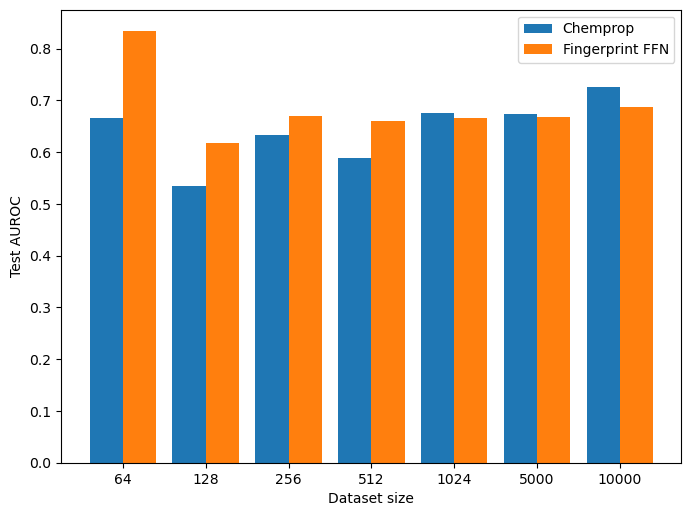

In [52]:
# this plot nicely shows the trend that as we allow more datapoints, chemprop eventually gets competitive (on a scaffold split)
make_bar_plot('scaffold', 'less')
plt.savefig('chemprop_vs_ecfp_bar_plot.pdf')

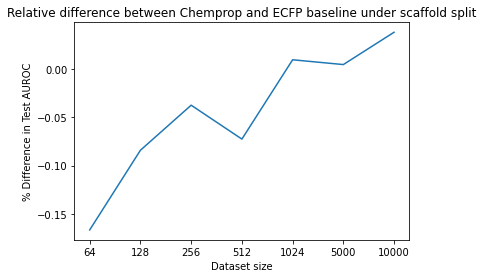

In [9]:
make_line_plot('scaffold', 'less')

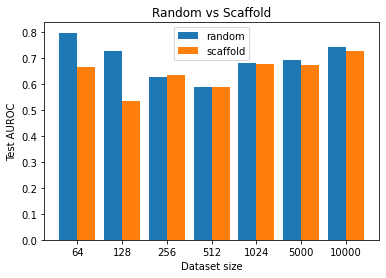

In [10]:
# We see that random outperforms scaffold on the majority of dataset thresholds (512 is questionable)
make_random_scaffold_bar_plot('less', 'chemprop')